In [ ]:
# default_exp bayesian
%load_ext autoreload
%autoreload 2
from nbdev import *
from utilities.ipynb_docgen import *

# Bayesian Blocks

> Partition a light curve with the Bayesian Block algorithm

The algorithm depends on a 'fitness' function of the light curve, an evaluation of the 
likelihoods for a set of sequential cells. There are two such, using the number of counts, and the Kerr likelihood.

- `CountFitness`
- `LikelihoodFitness`

See the [Bayesian Block reference](https://arxiv.org/pdf/1207.5578.pdf)

In [ ]:
#export
import os
import numpy as np
import pandas as pd
from astropy.stats.bayesian_blocks import FitnessFunc
from light_curves.lightcurve import get_lightcurve, flux_plot


In [ ]:
#collapse_hide
from light_curves.config import Config, Files, PointSource, Cache

lcs ={}
def data_setup(lcs = lcs, mjd_query='54750<t<54855', names=['Geminga','3C 279']):
    """
    ## Generate data sets for an AGN and a pulsar
    {printout}
    
    Choose the time interval, {mjd_query} to bracket a modest flare of the AGN.
     
    <table>
    <tr> <td>Pulsar</td><td>AGN</td></tr>
    <tr>
    <td>{fig1}</td> <td>{fig2}</td>
    </tr>
    </table>
    """
    
    from light_curves.config import Config, Files, PointSource
    from light_curves.lightcurve import get_lightcurve, flux_plot
    config = Config()
    files = Files()
    figs=[]
    plt.rc('font', size=20)
    with capture_print('printout') as printout:
        for i,name in enumerate(names):
            lcfull = get_lightcurve(config, files, PointSource(name))
            if mjd_query: lcfull
            lc = lcs[name] = lcfull.query(mjd_query) if mjd_query else lcfull
            fig= flux_plot(config,lc, fignum=i, title=name)
            figs.append(figure(fig, width=400))
    fig1, fig2 = figs
    mjd_query = mjd_query.replace('<', '&lt;')
    return locals()

if Files().valid:
    nbdoc(data_setup, lcs, mjd_query='')

## Generate data sets for an AGN and a pulsar
<details class="descripton" ><summary data-open="Hide " data-close="Show "> printout </summary> <p style="margin-left: 5%"><pre>using cache with key "lightcurve_Geminga", exists: True<br>using cache with key "lightcurve_3C 279", exists: True<br></pre></p> </details>

Choose the time interval,  to bracket a modest flare of the AGN.
 
<table>
<tr> <td>Pulsar</td><td>AGN</td></tr>
<tr>
<td><div class="nbdoc_image">
<a href="images/data_setup_fig_02.png"><figure>
   <img src="images/data_setup_fig_02.png" alt="Figure 2 at images/data_setup_fig_02.png" width=400> 
</figure></a></div>
</td> <td><div class="nbdoc_image">
<a href="images/data_setup_fig_03.png"><figure>
   <img src="images/data_setup_fig_03.png" alt="Figure 3 at images/data_setup_fig_03.png" width=400> 
</figure></a></div>
</td>
</tr>
</table>


In [ ]:
from light_curves.config import Cache
Cache('/tmp/lc_cache')

{'photons_Geminga': Path('/tmp/lc_cache/cache_file_270870a16929d2.pkl'),
 'exposure_Geminga': Path('/tmp/lc_cache/cache_file_52ab4b3386fa0447.pkl'),
 'lightcurve_Geminga': Path('/tmp/lc_cache/cache_file_25033e18d005d04.pkl'),
 'photons_3C 279': Path('/tmp/lc_cache/cache_file_d72f17a84dfd2e7.pkl'),
 'exposure_3C 279': Path('/tmp/lc_cache/cache_file_8762d8153c1b249.pkl'),
 'lightcurve_3C 279': Path('/tmp/lc_cache/cache_file_11d230d1c44af32.pkl')}

In [ ]:
#export
class CountFitness(FitnessFunc):
    """
    Adapted version of a astropy.stats.bayesian_blocks.FitnessFunc
    Considerably modified to give the `fitness function` access to the cell data.
    Implements the Event model using exposure instead of time.

    """

    def __init__(self, lc, p0=0.05,):
        """lc  : a LightCurve data table, with  exposure (e) and counts (n),
            as well as a representation of the likelihood for each cell
        """
        self.p0=p0
        self.df= df= lc
        N = self.N = len(df)
        # Invoke empirical function from Scargle 2012
        self.ncp_prior = self.p0_prior(N)

        #actual times for bin edges
        t = df.t.values
        dt = df.tw.values/2
        self.mjd = np.concatenate([t-dt, [t[-1]+dt[-1]] ] ) # put one at the end
        self.name = self.__class__.__name__
        self.setup()

    def setup(self):
        df = self.df

        # counts per cell
        self.nn = df.n.values
        assert min(self.nn)>0, 'Attempt to Include a cell with no contents'

        # edges and block_length use exposure as "time"
        e = df.e.values
        self.edges = np.concatenate([[0], np.cumsum(e)])
        self.block_length = self.edges[-1] - self.edges

    def __str__(self):
        
        return f'{self.name}: {self.N} cells, spanning {self.block_length[0]:.1f} days, prior={self.ncp_prior:.1f}'
        
    def __call__(self, R):
        """ The fitness function needed for BB algorithm
        For cells 0..R return array of length R+1 of the maximum log likelihoods for combined cells
        0..R, 1..R, ... R
        """
        # exposures and corresponding counts
        w_k = self.block_length[:R + 1] - self.block_length[R + 1]
        N_k = np.cumsum(self.nn[:R + 1][::-1])[::-1]

        # Solving eq. 26 from Scargle 2012 for maximum $\lambda$ gives
        return N_k * (np.log(N_k) - np.log(w_k))

    def fit(self):
        """Fit the Bayesian Blocks model given the specified fitness function.
        Refactored version using code from bayesian_blocks.FitnesFunc.fit
        Returns
        -------
        edges : ndarray
            array containing the (M+1) edges, in MJD units, defining the M optimal bins
        """
        # This is the basic Scargle algoritm, copied almost verbatum
        # ---------------------------------------------------------------

        # arrays to store the best configuration
        N = self.N
        best = np.zeros(N, dtype=float)
        last = np.zeros(N, dtype=int)

        # ----------------------------------------------------------------
        # Start with first data cell; add one cell at each iteration
        # ----------------------------------------------------------------
        for R in range(N):

            # evaluate fitness function
            fit_vec = self(R)

            A_R = fit_vec - self.ncp_prior
            A_R[1:] += best[:R]

            i_max = np.argmax(A_R)
            last[R] = i_max
            best[R] = A_R[i_max]

        # ----------------------------------------------------------------
        # Now find changepoints by iteratively peeling off the last block
        # ----------------------------------------------------------------
        change_points = np.zeros(N, dtype=int)
        i_cp = N
        ind = N
        while True:
            i_cp -= 1
            change_points[i_cp] = ind
            if ind == 0:
                break
            ind = last[ind - 1]
        change_points = change_points[i_cp:]

        return self.mjd[change_points]

In [ ]:
#collapse_hide

def doc_countfitness( fitness, light_curve_dict, source_name):
    """
    ### {class_name} test with source {source_name}
         
    Create object: `bbfitter = {class_name}(lc)`
    
    Object description:   {bbfitter}
    
    Then `bbfitter({n})` returns the values
        {values}
   
    Finally, the partition algorithm, 'bbfitter.fit()' returns {cffit}
    
    """
    
    lc = light_curve_dict[source_name]
    bbfitter = fitness(lc)
    class_name = bbfitter.name
    n = 10
    values  = np.array(bbfitter(n)).round()    
    cffit = bbfitter.fit()
    
    return locals()

In [ ]:
#hide
from light_curves.config import Config, Files, PointSource
from light_curves.lightcurve import get_lightcurve, flux_plot
if Files().valid:
    nbdoc(doc_countfitness, CountFitness, light_curve_dict = lcs, source_name='Geminga')
    nbdoc(doc_countfitness, CountFitness, light_curve_dict = lcs, source_name='3C 279')
     

### CountFitness test with source Geminga
     
Create object: `bbfitter = CountFitness(lc)`

Object description:   CountFitness: 3873 cells, spanning 4006.1 days, prior=6.6

Then `bbfitter(10)` returns the values
    [20740. 18904. 16936. 15025. 12911. 11012.  9013.  7083.  5177.  3313.
  1451.]

Finally, the partition algorithm, 'bbfitter.fit()' returns [54683. 55371. 55384. 55732. 55757. 56102. 56113. 56117. 56129. 56468.
 56506. 56530. 56650. 56659. 56727. 56734. 56931. 57014. 57022. 57197.
 57198. 57675. 57690. 58239. 58333. 58638. 58697.]


### CountFitness test with source 3C 279
     
Create object: `bbfitter = CountFitness(lc)`

Object description:   CountFitness: 3845 cells, spanning 4008.0 days, prior=6.6

Then `bbfitter(10)` returns the values
    [756. 704. 657. 586. 459. 379. 321. 265. 223. 127.  54.]

Finally, the partition algorithm, 'bbfitter.fit()' returns [54683. 54742. 54754. 54785. 54790. 54807. 54877. 54889. 54898. 55010.
 55025. 55039. 55047. 55108. 55118. 55132. 55299. 55444. 55459. 55482.
 55508. 55570. 55667. 55670. 55691. 55722. 55738. 55751. 55839. 55852.
 56162. 56202. 56217. 56457. 56560. 56579. 56621. 56630. 56635. 56638.
 56646. 56647. 56655. 56660. 56672. 56676. 56713. 56717. 56719. 56742.
 56747. 56749. 56750. 56753. 56755. 56758. 56799. 56857. 56866. 56871.
 56875. 56881. 56886. 56935. 56947. 56963. 56984. 56995. 57093. 57098.
 57149. 57152. 57156. 57184. 57187. 57189. 57190. 57191. 57212. 57216.
 57226. 57301. 57313. 57338. 57355. 57393. 57441. 57517. 57526. 57552.
 57554. 57613. 57661. 57680. 57705. 57745. 57757. 57787. 57807. 57826.
 57830. 57833. 57837. 57841. 57844. 57848. 57849. 57852. 57858. 57872.
 57885. 57892. 57894. 57902. 57926. 57928. 57929. 57940. 57941. 57945.
 57959. 57969. 57985. 57991. 58005. 58011. 58015. 58018. 58042. 58046.
 58062. 58078. 58084. 58087. 58089. 58116. 58117. 58118. 58119. 58120.
 58130. 58132. 58134. 58135. 58137. 58138. 58142. 58147. 58149. 58150.
 58155. 58161. 58169. 58174. 58184. 58220. 58222. 58223. 58224. 58225.
 58227. 58228. 58229. 58230. 58231. 58235. 58240. 58245. 58247. 58248.
 58251. 58258. 58260. 58265. 58268. 58269. 58272. 58274. 58276. 58278.
 58286. 58287. 58293. 58311. 58342. 58344. 58354. 58395. 58431. 58450.
 58454. 58476. 58574. 58583. 58650. 58697.]


In [ ]:
#export
class LikelihoodFitness(CountFitness):
    """ Fitness function that uses the full likelihood
    """
    
    def __init__(self, lc,  p0=0.05, npt=25):
        self.npt = npt
        super().__init__(lc, p0)
        
    def setup(self):
        df = self.df
        N = self.N
        
        def liketable(prep):
            return prep.create_table(self.npt)
        
        self.tables = df.fit.apply(liketable).values

    def __str__(self):
        return f'{self.__class__.__name__}: {self.N} cells,  prior={self.ncp_prior:.1f}'

    def __call__(self, R):
        
        a, y  = self.tables[R]
        x = np.linspace(*a)
        y = np.zeros(self.npt)
        rv = np.empty(R+1)
        for i in range(R, -1, -1): 
            a, yi = self.tables[i]
            xi = np.linspace(*a)
            y += np.interp(x, xi, yi, left=-np.inf, right=-np.inf)
            amax = np.argmax(y)
            rv[i] =y[amax]
        return rv    

In [ ]:
if Files().valid:
    nbdoc(doc_countfitness, LikelihoodFitness, light_curve_dict = lcs, source_name='Geminga')
    nbdoc(doc_countfitness, LikelihoodFitness, light_curve_dict = lcs, source_name='3C 279')
     

### LikelihoodFitness test with source Geminga
     
Create object: `bbfitter = LikelihoodFitness(lc)`

Object description:   LikelihoodFitness: 3873 cells,  prior=6.6

Then `bbfitter(10)` returns the values
    [-4. -3. -3. -2. -1. -1. -1. -1. -0. -0. -0.]

Finally, the partition algorithm, 'bbfitter.fit()' returns [54683. 55371. 55385. 55736. 55760. 56466. 56506. 56519. 56828. 56931.
 57014. 57021. 57197. 57198. 58248. 58300. 58637. 58697.]


### LikelihoodFitness test with source 3C 279
     
Create object: `bbfitter = LikelihoodFitness(lc)`

Object description:   LikelihoodFitness: 3845 cells,  prior=6.6

Then `bbfitter(10)` returns the values
    [-7. -6. -5. -5. -4. -4. -2. -2. -1. -0. -0.]

Finally, the partition algorithm, 'bbfitter.fit()' returns [54683. 54774. 54785. 54789. 54809. 54827. 54843. 54877. 54889. 54898.
 54972. 54973. 55010. 55025. 55034. 55043. 55046. 55091. 55107. 55123.
 55194. 55299. 55444. 55453. 55481. 55507. 55583. 55655. 55667. 55670.
 55693. 55728. 55738. 55745. 55827. 55839. 55845. 55961. 56204. 56215.
 56423. 56468. 56499. 56509. 56551. 56578. 56621. 56630. 56635. 56639.
 56646. 56647. 56651. 56659. 56672. 56676. 56717. 56719. 56742. 56744.
 56747. 56749. 56750. 56753. 56755. 56759. 56787. 56799. 56856. 56866.
 56871. 56875. 56881. 56887. 56982. 56984. 56994. 57037. 57093. 57100.
 57149. 57152. 57156. 57184. 57187. 57189. 57190. 57191. 57193. 57196.
 57200. 57212. 57216. 57224. 57301. 57321. 57335. 57363. 57406. 57442.
 57474. 57491. 57517. 57526. 57552. 57554. 57613. 57659. 57680. 57707.
 57757. 57787. 57807. 57826. 57830. 57833. 57837. 57841. 57844. 57848.
 57849. 57852. 57853. 57877. 57885. 57892. 57893. 57894. 57901. 57926.
 57928. 57929. 57932. 57938. 57940. 57941. 57952. 57963. 57965. 57969.
 57985. 57991. 58008. 58011. 58015. 58022. 58042. 58046. 58063. 58078.
 58084. 58087. 58092. 58098. 58111. 58116. 58117. 58118. 58119. 58120.
 58124. 58127. 58130. 58132. 58134. 58135. 58137. 58138. 58142. 58147.
 58149. 58150. 58155. 58159. 58169. 58174. 58184. 58220. 58222. 58223.
 58224. 58225. 58227. 58228. 58229. 58230. 58231. 58235. 58240. 58245.
 58247. 58248. 58251. 58258. 58260. 58265. 58268. 58269. 58272. 58273.
 58274. 58276. 58278. 58286. 58287. 58293. 58311. 58342. 58344. 58354.
 58397. 58431. 58450. 58454. 58476. 58490. 58502. 58507. 58536. 58551.
 58574. 58583. 58668. 58684. 58697.]


In [ ]:

def binned_weights(self, bins=None, contiguous=False):
    """ 
    Parameter:
        bins : None | float | array
            if None, use defaults
            Otherwise an array of MJD bin edges
        contiguous : bool
            if True ignore bins arg and use a list of contiguous exposure intervals

    Returns: a BinnedWeight object for access to each set of binned weights
        The object can be indexed, or used in a for loop
        bw[i] returns a  dict (t, tw, e, w, S, B)
        where t   : bin center time (MJD)
              tw  : bin width in days (assume 1 if not preseent)
              e   : associated fractional exposure
              w   : array of weights for the time range
              S,B : predicted source, background counts for this bin
        """
    if contiguous:
        assert bins is None, 'contiguous selected'
        a, b = self.get_contiguous_exposures()
        edges = np.empty(len(a)+1)
        edges[0] = a[0]
        edges[1:-1] = 0.5*(a[1:]+b[:-1])
        edges[-1]= b[-1]
        bins = edges
    return BinnedWeights(self, bins)   

In [ ]:
#export
def get_bb_partition(config, lc, fitness_class=CountFitness, p0=0.05):    

    """Perform Bayesian Block partition of the cells found in a light curve
    
    - lc : input light curve
    - fitness_func : 
    
    return edges for partition
    """
    cells = lc
    assert 'fit' in cells.columns, 'Expect the dataframe ho have the Poisson representation'
    assert issubclass(fitness_class,CountFitness), 'fitness_class wrong'
    # Now run the astropy Bayesian Blocks code using my version of the 'event' model
    fitness = fitness_class(lc, p0=p0)
    edges = fitness.fit() 

    if config.verbose>0:
        print(f'Partitioned {fitness.N} cells into {len(edges)-1} blocks, with prior {fitness.ncp_prior:.1f}'\
              f' using {fitness.__class__.__name__} ' )
    return edges

In [ ]:
#collapse_hide

def test_bb(lcs, name, fitness):
    """
    ### Display results of the BB partition for {name}
    
    {lc_fig}
    """
    files = Files()
    config = Config()
    
    lc = lcs[name]
    edges = get_bb_partition(config, lc, fitness) 
    lc_fig = flux_plot(config, lc, title=f'{name} partition with {fitness.__name__}')
    lc_fig.width=400
    ax = lc_fig.axes[0]
    edges = np.concatenate([edges, [edges[-1]] ])
    for  i,t in enumerate(edges[::2]):
        if 2*i+1==len(edges): break
        t2 = edges[2*i+1]
        ax.axvspan(t, t2, color='lightcyan')
    for t in edges:
        ax.axvline(t, ls=':', color='cyan')
    return locals()

if Files().valid:
    nbdoc(test_bb, lcs, '3C 279', CountFitness)
    nbdoc(test_bb, lcs, '3C 279', LikelihoodFitness)

Partitioned 3845 cells into 195 blocks, with prior 6.6 using CountFitness 


### Display results of the BB partition for 3C 279

<div class="nbdoc_image">
<a href="images/test_bb_fig_01.png"><figure>
   <img src="images/test_bb_fig_01.png" alt="Figure 1 at images/test_bb_fig_01.png" width=400> 
</figure></a></div>



Partitioned 3845 cells into 224 blocks, with prior 6.6 using LikelihoodFitness 


### Display results of the BB partition for 3C 279

<div class="nbdoc_image">
<a href="images/test_bb_fig_01.png"><figure>
   <img src="images/test_bb_fig_01.png" alt="Figure 1 at images/test_bb_fig_01.png" width=400> 
</figure></a></div>



In [ ]:
source = PointSource('Geminga')
config = Config()
files = Files()
edges = get_bb_partition(config, lcs['Geminga'], LikelihoodFitness) 
lcx = get_lightcurve(config, files, source, edges)


Partitioned 3873 cells into 17 blocks, with prior 6.6 using LikelihoodFitness 
restored photons_Geminga from cache

	Selected 1313726 photons within 5 deg of  (195.13,4.27)
	Energies: 100.0-1000000 MeV
	Dates:    2008-08-04 15:46 - 2019-08-03 01:17
	MJD  :    54682.7          - 58698.1         
Load weights from file /mnt/d/OneDrive/fermi/weight_files/Geminga_weights.pkl
	Found: PSR J0633+1746 at (195.14, 4.27)
	Applyng weights: 240 / 1313726 photon pixels are outside weight region
	233109 weights set to NaN
restore exposure_Geminga from cache
2695715 entries, MJD 54683 - 58698
Loaded 9 / 17 cells with exposure > 0.3 for light curve analysis
first cell: t                                                      55027
tw                                                       688
e                                                    3.28107
n                                                     207832
w          [244, 214, 174, 5, 246, 150, 187, 65, 91, 215,...
S                                

AttributeError: 'AxesSubplot' object has no property 'step'

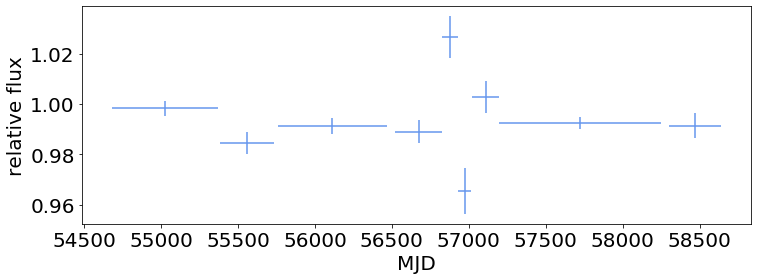

In [ ]:
fig = flux_plot(config,lcx, step=True); 

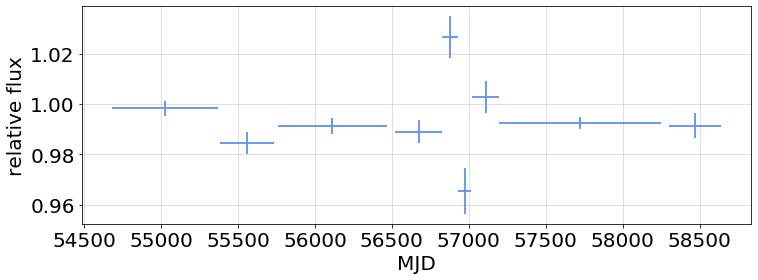

In [ ]:
ax = fig.axes[0]
flux_plot(config, lcx, ax=ax)

In [ ]:
lcx.iloc[0], len(lcx)

(t                                                  55027
 tw                                                   688
 n                                                 207832
 e                                                3.28107
 fit    light_curves.loglike.PoissonRep: flux: 0.998[1...
 Name: 0, dtype: object,
 9)

In [ ]:
lcx

,t,tw,n,e,fit
0,55027.0,688.0,207832,3.281069,light_curves.loglike.PoissonRep: flux: 0.998[1...
2,55560.5,351.0,96416,1.527257,light_curves.loglike.PoissonRep: flux: 0.985[1...
4,56113.0,706.0,190965,3.020903,light_curves.loglike.PoissonRep: flux: 0.991[1...
7,56673.5,309.0,84043,1.334203,light_curves.loglike.PoissonRep: flux: 0.989[1...
8,56879.5,103.0,28168,0.434166,light_curves.loglike.PoissonRep: flux: 1.027[1...
9,56972.5,83.0,20961,0.336465,light_curves.loglike.PoissonRep: flux: 0.966[1...
11,57109.0,176.0,45616,0.708227,light_curves.loglike.PoissonRep: flux: 1.003[1...
13,57723.0,1050.0,285243,4.501777,light_curves.loglike.PoissonRep: flux: 0.992[1...
15,58468.5,337.0,74075,1.161036,light_curves.loglike.PoissonRep: flux: 0.991[1...


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_load_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 07_cells.ipynb.
Converted 09_poisson.ipynb.
Converted 10_loglike.ipynb.
Converted 11_lightcurve.ipynb.
Converted 12_instructions.ipynb.
Converted 13_kerr_comparison.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Tue Dec 15 10:05:02 PST 2020
